# Problem 1: Bayesian Density Estimation
By: Griffin Hosseinzadeh (2025 May 6)  
Inspired by a notebook by LM Walkowicz (2019 June 14)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.visualization as viz
from scipy import stats
from sklearn.neighbors import KernelDensity
plt.rcParams['figure.dpi'] = 150

Here I'm simulating some data. Just run this cell to generate a list of values `x`.

In [2]:
x = np.concatenate([stats.cauchy(-5, 1.8).rvs(500),
                    stats.cauchy(-4, 0.8).rvs(2000),
                    stats.cauchy(-1, 0.3).rvs(500),
                    stats.cauchy(2, 0.8).rvs(1000),
                    stats.cauchy(4, 1.5).rvs(500)])

# truncate values to a reasonable range
x = x[(x > -15) & (x < 15)]

Make a histogram of these values using `plt.hist`. (Use `density=True` throughout this exercise, so the y-axes are comparable.) How many peaks does this data set have?

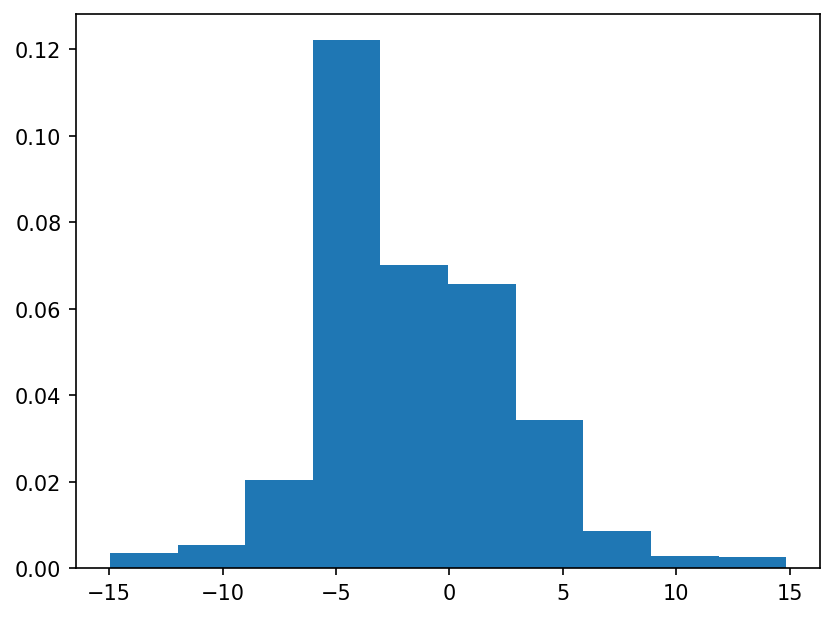

In [3]:
plt.hist(x, density=True)
plt.show()

Now make a histogram using the `'auto'` binning in Matplotlib. What does it think the right number of bins should be? How many peaks does this data set have?

42 bins


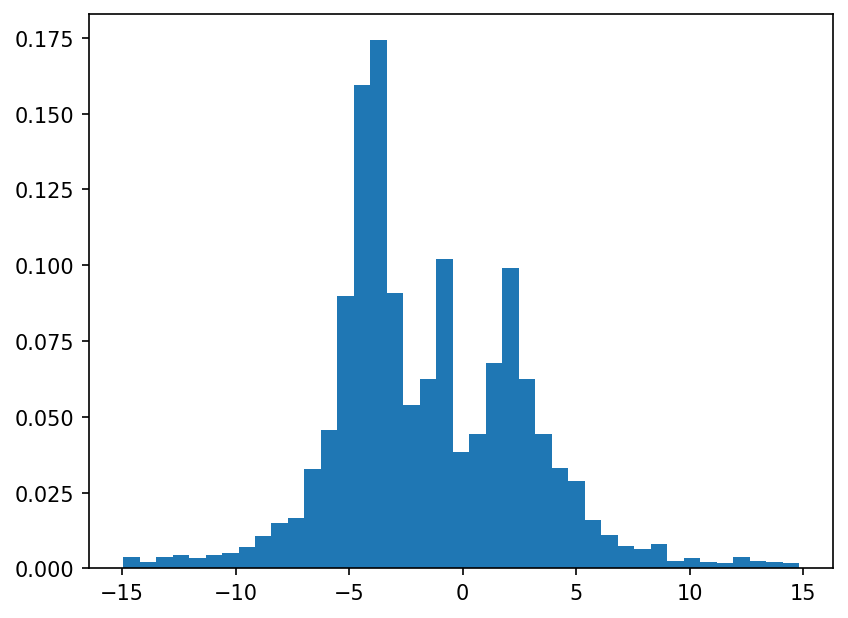

In [4]:
n, b, p = plt.hist(x, bins='auto', density=True)
print(len(b), 'bins')

Increase the number of bins even further. Is there a point where it gets too high? If so, why?

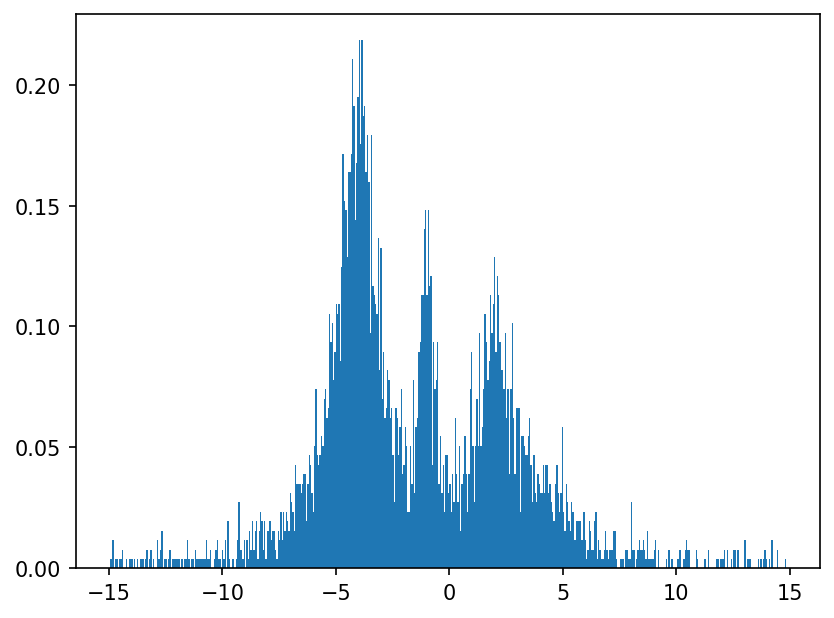

In [5]:
plt.hist(x, bins=500, density=True)
plt.show()

*The point where there are too many bins is when there are gaps in the histogram due to the randomness inherent in measurements rather than the actual form of the data.*

Now make a histogram using Bayesian blocks. Hint: try the `astropy.visualization.hist` function. How many bins does this have? Can you see all the peaks?

19 bins


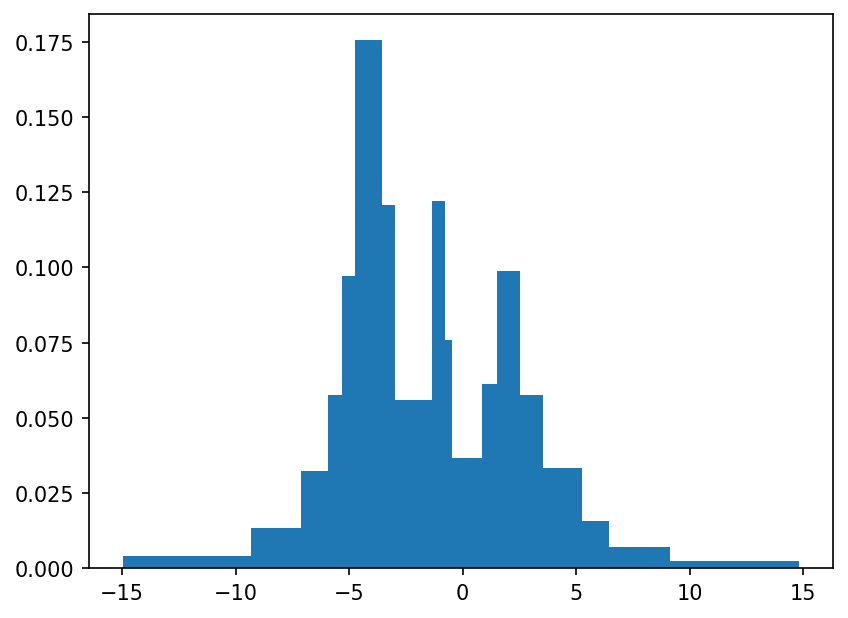

In [6]:
n, b, p = viz.hist(x, bins='blocks', density=True)
print(len(b), 'bins')

*Can see all the peaks, but no gaps in the data*

Try making the Bayesian blocks histogram *without* `density=True`. What do you notice? Is this a good idea?

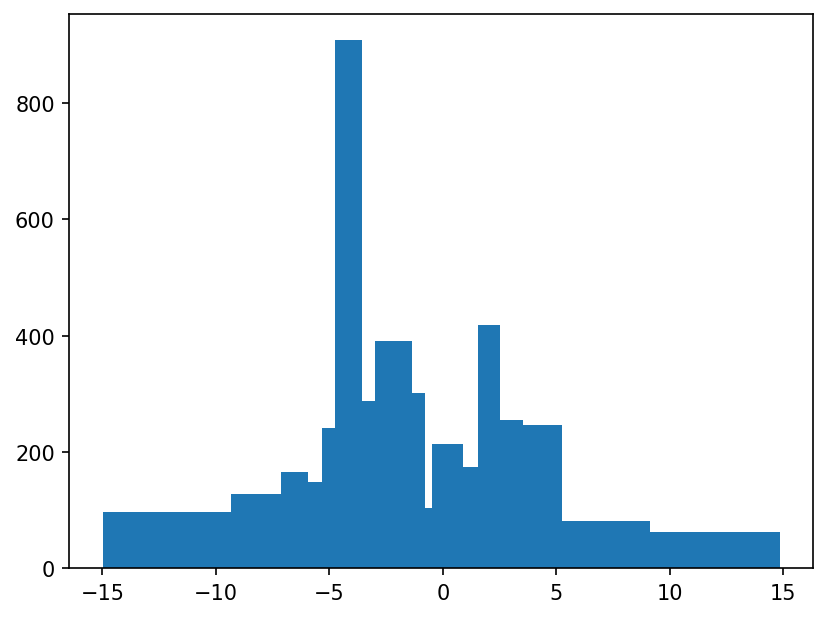

In [7]:
viz.hist(x, bins='blocks')
plt.show()

*When not using density, it is harder to understand the meaning of the histogram because the values on the y axis are dependent on the number of measurements taken.*

Now let's try making a KDE instead. Try a few different values for the bandwidth until you find one you like.

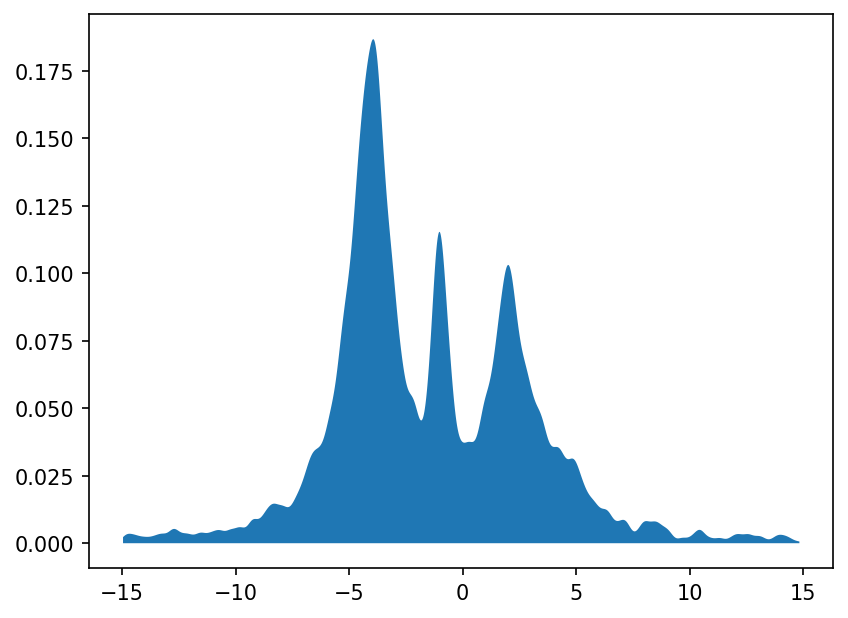

In [8]:
kde = KernelDensity(bandwidth=0.2, kernel='gaussian')
kde.fit(x[:, np.newaxis])

x_fit = np.arange(np.min(x), np.max(x), .01)
log_y_fit = kde.score_samples(x_fit[:, np.newaxis]) #score_samples gives the log-likelihood
y_fit = np.exp(log_y_fit)

plt.fill_between(x_fit, y_fit)

Plot all of these density estimates on top of each other using `histtype='step'` and compare them.

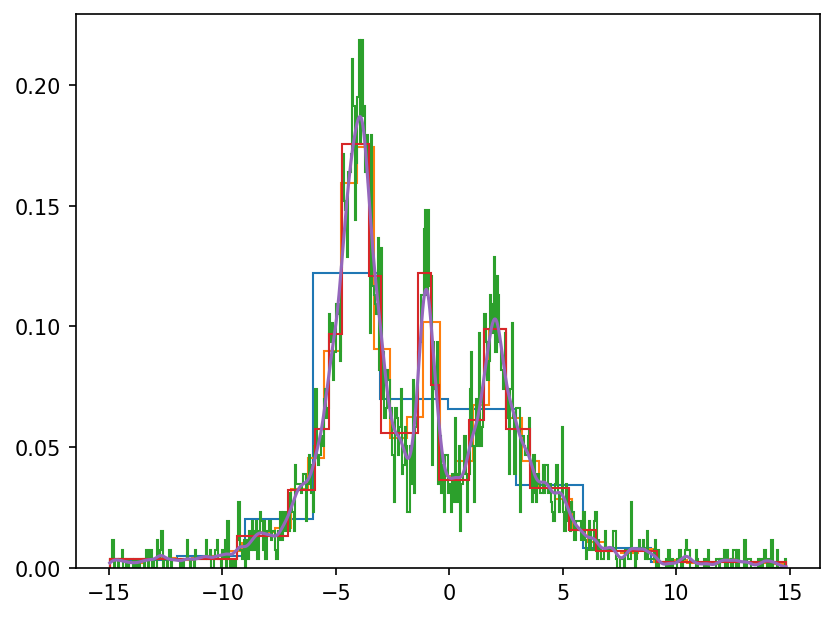

In [9]:
plt.hist(x, histtype='step', density=True)
plt.hist(x, bins='auto', histtype='step', density=True)
plt.hist(x, bins=500, histtype='step', density=True)
viz.hist(x, bins='blocks', histtype='step', density=True)
plt.plot(x_fit, y_fit)
plt.show()

*The KDE seems to be the best representation of the data, and the variable bin size is the best of the histograms*

# Problem 2: Gaussian Process Regression
By: Griffin Hosseinzadeh (2019 April 17)  
Updated 2025 May 6

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import george
from astropy.table import Table

## Read the Light Curve
I have given you light curve data for the Type Ibn supernova PTF11rfh in the file `PTF11rfh.table`, which is readable with the `astropy.table` module. (Hint: `format='ascii.fixed_width'`.) For this example, let's fit the light curve in counts rather than magnitudes. Select only points observed in the $r$ or $R$ filter and have a measurement in counts. Plot it to see what we're working with. (For non-astronomers, MJD is a measure of time in days.)

In [11]:
data = Table.read('PTF11rfh.table', format='ascii.fixed_width')
print(data[0]['filt'])
data = Table([d for i, d in enumerate(data) if (d['filt'].lower() == 'r' and not isinstance(d['counts'], np.ma.core.MaskedConstant))]) # select r/R-band with counts
data

R


MJD,counts,dcounts,zp,nondet,filt,source,mag,dmag,limmag,flam,dflam
float64,float64,float64,float64,str5,str1,str3,float64,float64,int64,int64,int64
55889.091,19.7,36.8,27.0,True,R,P48,21.89257731651705,nan,--,--,--
55889.125,22.2,45.1,27.0,True,R,P48,21.671755508505942,nan,--,--,--
55889.167,-7.8,49.6,27.0,True,R,P48,21.56849267197535,nan,--,--,--
55891.167,-17.1,54.8,27.0,True,R,P48,21.46024546698992,nan,--,--,--
55892.099,99.8,107.9,27.0,True,R,P48,20.724643251493568,nan,--,--,--
55892.142,-128.1,64.0,27.0,True,R,P48,21.291746928241125,nan,--,--,--
55892.178,-13.6,107.1,27.0,True,R,P48,20.732723186121206,nan,--,--,--
55893.098,-57.5,56.9,27.0,True,R,P48,21.419416197213167,nan,--,--,--
55893.136,-85.3,64.3,27.0,True,R,P48,21.28666943089029,nan,--,--,--


<ErrorbarContainer object of 3 artists>

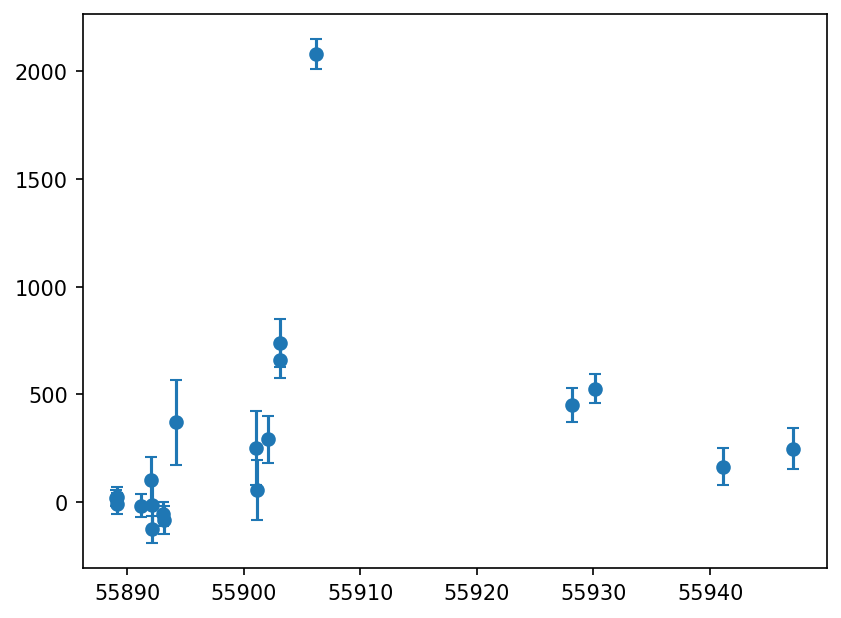

In [12]:
x = data['MJD']
y = data['counts']
dy =  data['dcounts']
plt.scatter(x, y)
plt.errorbar(x, y, yerr=dy, ls='', capsize=3)

## Try a Polynomial Fit
Hint: use `np.polyfit` and `np.polyval`. Try different degree polynomials to see if you are able to get a good fit.

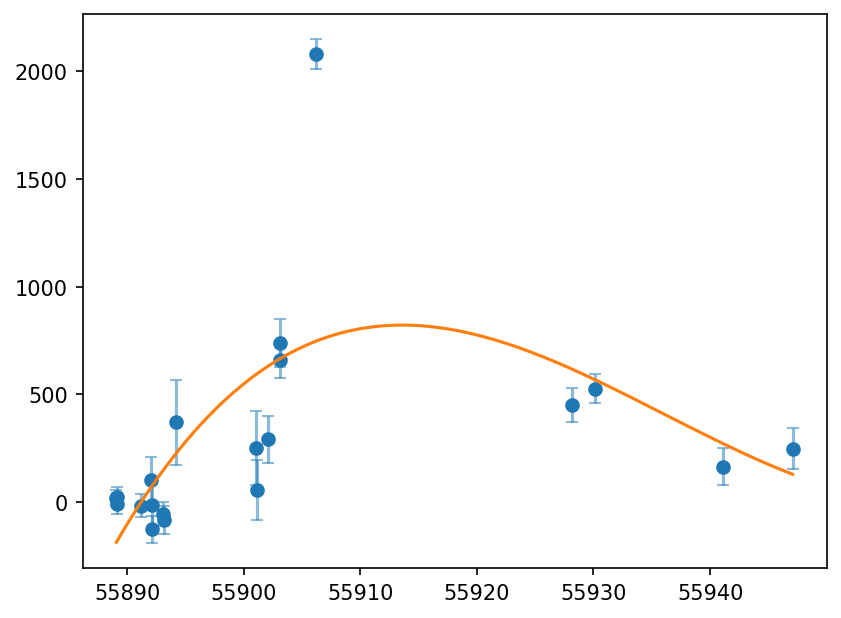

In [13]:
x_fit = np.arange(np.min(x), np.max(x), .01)

y_fit_poly = np.polyfit(x, y, deg=3)

y_fit = np.zeros_like(x_fit) # == np.polyval(y_fit_poly, x_fit)
for i, p in enumerate(np.flip(y_fit_poly)): 
    y_fit += p*np.pow(x_fit, i)

plt.scatter(x,y)
plt.errorbar(x, y, yerr=dy, ls='', capsize=3, alpha=0.5)
plt.plot(x_fit, y_fit)

Don't spend too much time on this. I could not get it to give a reasonable result.

## Try a Gaussian Process
We are using a package called `george` to make Gaussian process regression easier. It has all of the functions you need build in.

First we need to initialize a kernel (`george.kernels`). You should normalize the kernel by the total variance of the data points. Think about what hyperparameters would be appropriate for fitting your data. We can always optimize them later.

In [14]:
kernel = np.var(y) * george.kernels.Matern32Kernel(3.0) #normalize by variance

Initialize a Gaussian process with the kernel you chose. This is all contained within the `george.GP` object, which we will use for the remainder of the calculations.

In [15]:
gp = george.GP(kernel)

The first step is to precompute the covariance matrix at the observed times.

In [16]:
gp.compute(x, dy)

The second and last step is to use the Gaussian process to predict the light curve at the times in `x_fit`, given the observed data points in `y`. This should give you an interpolation **and** and uncertainty on the interpolation.

In [17]:
x_pred = np.linspace(np.min(x), np.max(x), int(1e4), endpoint=True)
pred, pred_var = gp.predict(y, x_pred, return_var=True)
scaled_var = np.sqrt(pred_var) #because covariance is σ^2

Plot the results of your Gaussian process fit and compare to the data and the polynomial fit. Hint: display the uncertainties using `plt.fill_between`.

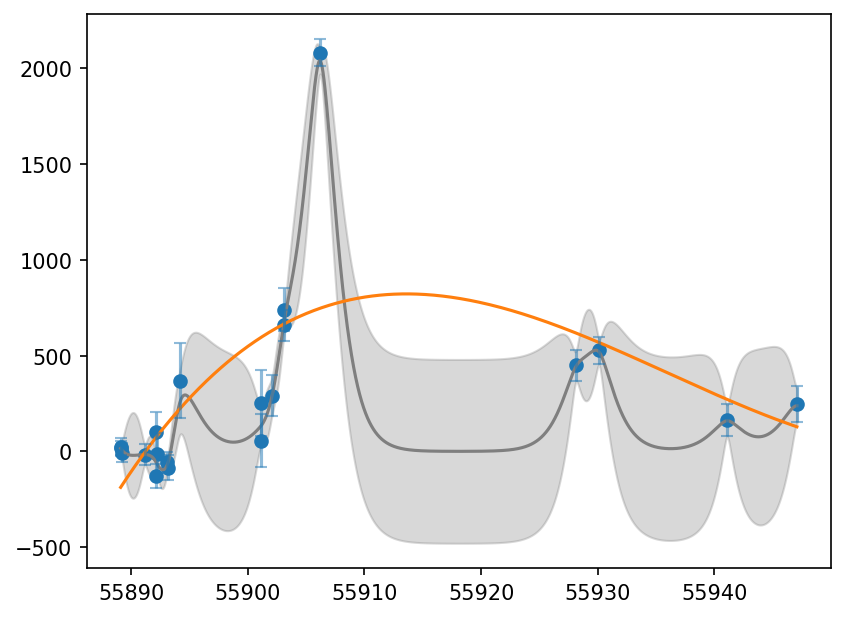

In [18]:
plt.fill_between(x_pred, pred - scaled_var, pred + scaled_var, alpha=0.3, color='tab:gray')
plt.plot(x_pred, pred, color='tab:gray')

plt.plot(x_fit, y_fit, color='tab:orange')

plt.scatter(x,y, c='tab:blue')
plt.errorbar(x, y, yerr=dy, ls='', capsize=3, alpha=0.5, c='tab:blue')

plt.show()

Once you get a reasonable fit, try adjusting the kernel and/or hyperparameters to see what effects they have.

## Take-Away Message
Gaussian process regression is a very easy and powerful way to interpolate an arbitrary set of data points with a nonparametric function. Furthermore, it gives you uncertainties on the interpolation and handles covariance between points correctly.

## Other Things to Try (Optional)
- Optimize the Gaussian process using the technique described in the George tutorial: https://george.readthedocs.io/en/latest/tutorials/first/.
- Marginalize over the hyperparameter(s) using MCMC.
- Try products of different kernels to see if you can get a better fit.